In [101]:
# import module 
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [41]:
# Read Data 
data_train = pd.read_csv("../data/train_preprocess.tsv", sep="\t", header=None)
data_valid = pd.read_csv("../data/valid_preprocess.tsv", sep="\t", header=None)
data_test = pd.read_csv("../data/test_preprocess.tsv", sep="\t", header=None)

In [42]:
# Analisis size data 
def analisisData(dataset, typeOfDataset):
    print(f"Banyaknya data {typeOfDataset}: {dataset.shape[0]}")
    print(f"Contoh 5 field dari {typeOfDataset}: ")
    print(dataset.head())
    print(f"Distribusi frekuensi label {typeOfDataset}")
    print(dataset[1].value_counts())

analisisData(data_train, "data train")
print("\n")
analisisData(data_valid, "data validation")
print("\n")
analisisData(data_test, "data test")
print("\n")

Banyaknya data data train: 11000
Contoh 5 field dari data train: 
                                                   0         1
0  warung ini dimiliki oleh pengusaha pabrik tahu...  positive
1  mohon ulama lurus dan k212 mmbri hujjah partai...   neutral
2  lokasi strategis di jalan sumatera bandung . t...  positive
3  betapa bahagia nya diri ini saat unboxing pake...  positive
4  duh . jadi mahasiswa jangan sombong dong . kas...  negative
Distribusi frekuensi label data train
1
positive    6416
negative    3436
neutral     1148
Name: count, dtype: int64


Banyaknya data data validation: 1260
Contoh 5 field dari data validation: 
                                                   0         1
0  meski masa kampanye sudah selesai , bukan bera...   neutral
1                                         tidak enak  negative
2  restoran ini menawarkan makanan sunda . kami m...  positive
3  lokasi di alun alun masakan padang ini cukup t...  positive
4  betapa bejad kader gerindra yang anggota dpr

In [43]:
# Dekomposisi dataset menjadi nilai X dan Y
def dekomposisi(dataset):
    return dataset.drop(columns=[dataset.columns[1]]), dataset[[dataset.columns[1]]]

X_train, Y_train = dekomposisi(data_train)
X_test, Y_test = dekomposisi(data_test)
X_valid, Y_valid = dekomposisi(data_valid)
print(X_train)

                                                       0
0      warung ini dimiliki oleh pengusaha pabrik tahu...
1      mohon ulama lurus dan k212 mmbri hujjah partai...
2      lokasi strategis di jalan sumatera bandung . t...
3      betapa bahagia nya diri ini saat unboxing pake...
4      duh . jadi mahasiswa jangan sombong dong . kas...
...                                                  ...
10995                                       tidak kecewa
10996  enak rasa masakan nya apalagi kepiting yang me...
10997        hormati partai-partai yang telah berkoalisi
10998  pagi pagi di tol pasteur sudah macet parah , b...
10999  meskipun sering belanja ke yogya di riau junct...

[11000 rows x 1 columns]


In [44]:
# Preprocessing 
# 1. Lowercase, membuat seluruh data train dan validation menjadi lowercase
def lowerCase(df):
    return df.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

X_train = lowerCase(X_train)
Y_train = lowerCase(Y_train)
X_test = lowerCase(X_test)
Y_test = lowerCase(Y_test)
X_valid = lowerCase(X_valid)
Y_valid = lowerCase(Y_valid)

In [45]:
# Preprocessing
# 2. Masked Data, melakukan masked terhadap data-data seperti nomor telepon, email, dan angka
def masked_all_important(text):
    email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    masked_text = re.sub(email_regex, '_email_', text)
    phone_regex = r'\b\d{3}-\d{3}-\d{4}\b'
    masked_text = re.sub(phone_regex, '_phone_', masked_text)
    number_regex = r'\b\d+\b'  # Regex untuk mencocokkan angka
    masked_text = re.sub(number_regex, '_number_', masked_text)
    return masked_text

X_train.iloc[:, 0] = X_train.iloc[:, 0].apply(masked_all_important)
X_test.iloc[:, 0] = X_test.iloc[:, 0].apply(masked_all_important)
X_valid.iloc[:, 0] = X_valid.iloc[:, 0].apply(masked_all_important)

In [46]:
# Preprocessing 
# 3. Tokenization, membuat train terpisah dalam bentuk token-token
def tokenization(X_train):
    X_train = [word_tokenize(text) for text in X_train]
    return X_train

X_train = tokenization(X_train.iloc[:, 0])  
X_test = tokenization(X_test.iloc[:, 0])
X_valid = tokenization(X_valid.iloc[:, 0])

for i in range(4):
    print(f"Sample {i+1}: {X_train[i]}")

Sample 1: ['warung', 'ini', 'dimiliki', 'oleh', 'pengusaha', 'pabrik', 'tahu', 'yang', 'sudah', 'puluhan', 'tahun', 'terkenal', 'membuat', 'tahu', 'putih', 'di', 'bandung', '.', 'tahu', 'berkualitas', ',', 'dipadu', 'keahlian', 'memasak', ',', 'dipadu', 'kretivitas', ',', 'jadilah', 'warung', 'yang', 'menyajikan', 'menu', 'utama', 'berbahan', 'tahu', ',', 'ditambah', 'menu', 'umum', 'lain', 'seperti', 'ayam', '.', 'semuanya', 'selera', 'indonesia', '.', 'harga', 'cukup', 'terjangkau', '.', 'jangan', 'lewatkan', 'tahu', 'bletoka', 'nya', ',', 'tidak', 'kalah', 'dengan', 'yang', 'asli', 'dari', 'tegal', '!']
Sample 2: ['mohon', 'ulama', 'lurus', 'dan', 'k212', 'mmbri', 'hujjah', 'partai', 'apa', 'yang', 'harus', 'diwlh', 'agar', 'suara', 'islam', 'tidak', 'pecah-pecah']
Sample 3: ['lokasi', 'strategis', 'di', 'jalan', 'sumatera', 'bandung', '.', 'tempat', 'nya', 'nyaman', 'terutama', 'sofa', 'di', 'lantai', '_number_', '.', 'paella', 'nya', 'enak', ',', 'sangat', 'pas', 'dimakan', 'denga

In [47]:
# Preprocessing
# 4. Stemming, menghilangkan imbuhan-imbuhan kalimat dan juga diharapkan dengan stemming dapat membantu untuk memperbaiki kalimat yang salah/typo
def stemming(X_train):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_text = []
    for sentence in X_train:
        stemmed_words = [stemmer.stem(word) for word in sentence]
        stemmed_text.append(stemmed_words)
    return stemmed_text

X_train = stemming(X_train)
X_test = stemming(X_test)
X_valid = stemming(X_valid)
for i in range(4):
    print(f"Sample {i+1}: {X_train[i]}")

Sample 1: ['warung', 'ini', 'milik', 'oleh', 'usaha', 'pabrik', 'tahu', 'yang', 'sudah', 'puluh', 'tahun', 'kenal', 'buat', 'tahu', 'putih', 'di', 'bandung', '', 'tahu', 'kualitas', '', 'padu', 'ahli', 'masak', '', 'padu', 'kretivitas', '', 'jadi', 'warung', 'yang', 'saji', 'menu', 'utama', 'bahan', 'tahu', '', 'tambah', 'menu', 'umum', 'lain', 'seperti', 'ayam', '', 'semua', 'selera', 'indonesia', '', 'harga', 'cukup', 'jangkau', '', 'jangan', 'lewat', 'tahu', 'bletoka', 'nya', '', 'tidak', 'kalah', 'dengan', 'yang', 'asli', 'dari', 'tegal', '']
Sample 2: ['mohon', 'ulama', 'lurus', 'dan', 'k212', 'mmbri', 'hujjah', 'partai', 'apa', 'yang', 'harus', 'diwlh', 'agar', 'suara', 'islam', 'tidak', 'pecah']
Sample 3: ['lokasi', 'strategis', 'di', 'jalan', 'sumatera', 'bandung', '', 'tempat', 'nya', 'nyaman', 'utama', 'sofa', 'di', 'lantai', 'number', '', 'paella', 'nya', 'enak', '', 'sangat', 'pas', 'makan', 'dengan', 'minum', 'bir', 'dingin', '', 'appetiser', 'nya', 'juga', 'enak', '']
Sam

In [57]:
# Preprocessing 
# 5. Menghapus tanda baca. Karena khawatirnya data train jadi bias gara-gara dominannya tanda baca
def remove_punctuation(word):
    return word.translate(str.maketrans('', '', string.punctuation))

In [59]:
# Preprocessing 
# 6. Penanganan Stop Word 
# Feature Extraction : Pembuatan Vector dengan bantuan TF-IDF agar kata-kata dominan yang berpengaruh pada label tidak bias oleh kata-kata yang sering digunakan

# Proses join hasil token kemudian di hapus tanda bacanya
X_train = [' '.join(remove_punctuation(word) for word in words) for words in X_train]
X_test = [' '.join(remove_punctuation(word) for word in words) for words in X_test]
X_valid = [' '.join(remove_punctuation(word) for word in words) for words in X_valid]

# Vectorization dengan tfidf
tfidf_vec = TfidfVectorizer(min_df=10, token_pattern=r'[a-zA-Z]+')
X_train_tfidf = tfidf_vec.fit_transform(X_train)  # Fit pada data pelatihan
X_test_tfidf = tfidf_vec.transform(X_test)        # Transform data uji
X_valid_tfidf = tfidf_vec.transform(X_valid) 

In [51]:
# Classification 
# 1. Model SVM
model_svm = svm.SVC(C=8.0, kernel='linear')
model_svm.fit(X_train_tfidf, Y_train.values.ravel())

# Evaluasi model dengan data validasi
val_pred = model_svm.predict(X_valid_tfidf)
val_acc = accuracy_score(Y_valid, val_pred)

print(f"Validation Accuracy: {val_acc}")

Validation Accuracy: 0.8484126984126984


In [52]:
# Classification 
# 1. Model Decision Tree
model_dec = DecisionTreeClassifier(max_depth=10, random_state=0)
model_dec.fit(X_train_tfidf, Y_train)

# Evaluasi model dengan data validasi
val_pred = model_dec.predict(X_valid_tfidf)
val_acc = accuracy_score(Y_valid, val_pred)

print(f"Validation Accuracy: {val_acc}")

Validation Accuracy: 0.7428571428571429


In [53]:
# Classification 
# 1. Model Gaussian Naive Bayes
model_gnb = GaussianNB()
model_gnb.fit(X_train_tfidf.toarray(), Y_train.values.ravel())

# Evaluasi model dengan data validasi
val_pred = model_gnb.predict(X_valid_tfidf.toarray())
val_acc = accuracy_score(Y_valid, val_pred)

print(f"Validation Accuracy: {val_acc}")

Validation Accuracy: 0.692063492063492


In [54]:
# Classification 
# 1. Model Logistic Regression
model_lg = LogisticRegression()
model_lg.fit(X_train_tfidf, Y_train.values.ravel())

# Evaluasi model dengan data validasi
val_pred = model_lg.predict(X_valid_tfidf)
val_acc = accuracy_score(Y_valid, val_pred)

print(f"Validation Accuracy: {val_acc}")

Validation Accuracy: 0.8722222222222222


In [56]:
# Prediksi menggunakan setiap model
svm_pred = model_svm.predict(X_test_tfidf)
dec_pred = model_dec.predict(X_test_tfidf)
gnb_pred = model_gnb.predict(X_test_tfidf.toarray())
lg_pred = model_lg.predict(X_test_tfidf)

# Evaluasi SVM
print("SVM Model:")
print(f"Accuracy: {accuracy_score(Y_test, svm_pred)}")
print(f"Precision: {precision_score(Y_test, svm_pred, average='weighted')}")
print(f"Recall: {recall_score(Y_test, svm_pred, average='weighted')}")
print(f"F1-Score: {f1_score(Y_test, svm_pred, average='weighted')}")

# Evaluasi Decision Tree
print("\nDecision Tree Model:")
print(f"Accuracy: {accuracy_score(Y_test, dec_pred)}")
print(f"Precision: {precision_score(Y_test, dec_pred, average='weighted')}")
print(f"Recall: {recall_score(Y_test, dec_pred, average='weighted')}")
print(f"F1-Score: {f1_score(Y_test, dec_pred, average='weighted')}")

# Evaluasi Gaussian Naive Bayes
print("\nGaussian Naive Bayes Model:")
print(f"Accuracy: {accuracy_score(Y_test, gnb_pred)}")
print(f"Precision: {precision_score(Y_test, gnb_pred, average='weighted')}")
print(f"Recall: {recall_score(Y_test, gnb_pred, average='weighted')}")
print(f"F1-Score: {f1_score(Y_test, gnb_pred, average='weighted')}")

# Evaluasi Logistic Regression
print("\nLogistic Regression Model:")
print(f"Accuracy: {accuracy_score(Y_test, lg_pred)}")
print(f"Precision: {precision_score(Y_test, lg_pred, average='weighted')}")
print(f"Recall: {recall_score(Y_test, lg_pred, average='weighted')}")
print(f"F1-Score: {f1_score(Y_test, lg_pred, average='weighted')}")

SVM Model:
Accuracy: 0.732
Precision: 0.7363154097460536
Recall: 0.732
F1-Score: 0.7270009130957148

Decision Tree Model:
Accuracy: 0.506
Precision: 0.5809379152348224
Recall: 0.506
F1-Score: 0.4594545619444948

Gaussian Naive Bayes Model:
Accuracy: 0.45
Precision: 0.5617586550508236
Recall: 0.45
F1-Score: 0.45171843445713383

Logistic Regression Model:
Accuracy: 0.744
Precision: 0.7637356271435054
Recall: 0.744
F1-Score: 0.7324233809329526


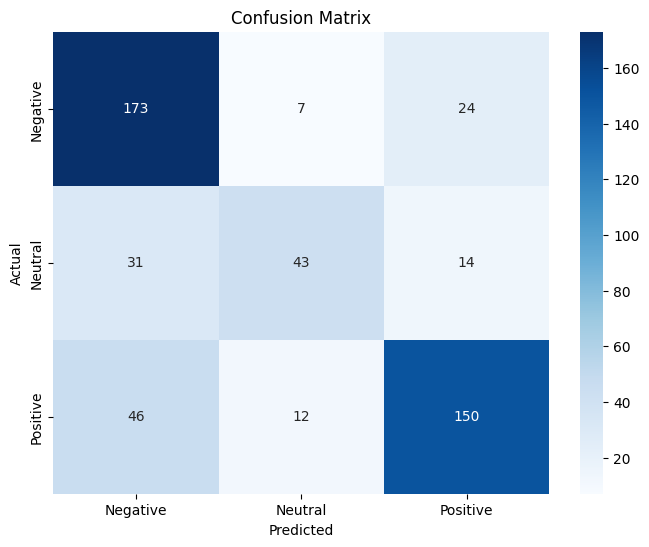

Classification Report:
              precision    recall  f1-score   support

    Negative       0.69      0.85      0.76       204
     Neutral       0.69      0.49      0.57        88
    Positive       0.80      0.72      0.76       208

    accuracy                           0.73       500
   macro avg       0.73      0.69      0.70       500
weighted avg       0.74      0.73      0.73       500



In [92]:
# Membuat confusion matrix
cm = confusion_matrix(Y_test, svm_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Laporan klasifikasi
print("Classification Report:")
print(classification_report(Y_test, svm_pred, target_names=['Negative', 'Neutral', 'Positive']))


In [106]:
# Mendapatkan indeks dari prediksi yang salah
X_test_original = data_test
misclassified_indices = np.where(svm_pred != Y_test.values.ravel())[0]

# Menampilkan beberapa sampel dari data yang salah diprediksi
print("\nContoh data yang salah diprediksi:")
for i in misclassified_indices[:5]:  
    print(f"Teks: {X_test_original.iloc[i, 0]}")
    print(f"Asli: {Y_test.values[i][0]}, Prediksi: {svm_pred[i]}")
    print('-' * 80)


Contoh data yang salah diprediksi:
Teks: kemarin gue datang ke tempat makan baru yang ada di dago atas . gue kira makanan nya enak karena harga nya mahal . ternyata , boro-boro . tidak mau lagi deh ke tempat itu . sudah mana tempat nya juga tidak nyaman banget , terlalu sempit .
Asli: negative, Prediksi: positive
--------------------------------------------------------------------------------
Teks: kalau dipikir-pikir , sebenarnya tidak ada yang bisa dibanggakan dari jokowi . pertama , dia tidak bisa nepatin janji . kedua , kerjaan nya selalu pencitraan . ketiga , dia tidak pro rakyat . sudahlah . ku sudah terlanjur kecewa .
Asli: negative, Prediksi: positive
--------------------------------------------------------------------------------
Teks: kata nya dapat promo 100 ribu . tapi setelah di bayar di atm - nya ternyata harga normal . sudah saya kirim email tapi tidak ada balasan . mengecewakan .
Asli: negative, Prediksi: neutral
--------------------------------------------------------

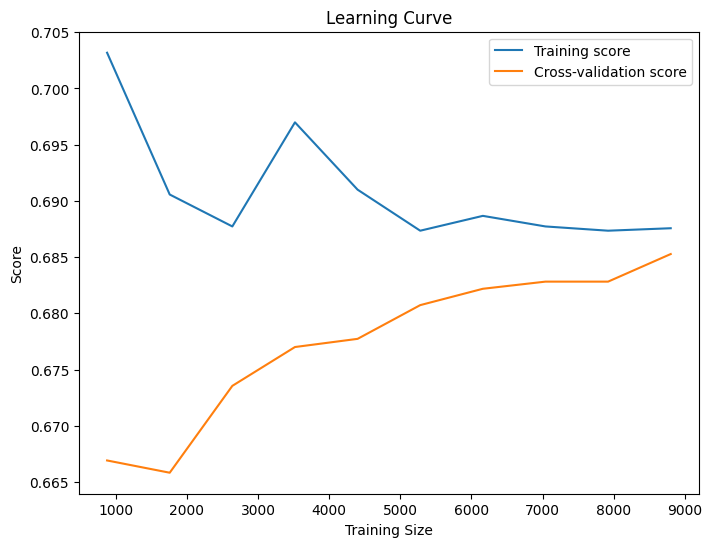

In [104]:
# Analisis underfitting atau overfitting saat proses training

train_sizes, train_scores, test_scores = learning_curve(
    model_svm, X_train_tfidf, Y_train.values.ravel(), cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, label="Training score")
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()
